In [1]:
import sys
sys.path.append("../src/data") 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from feature_builder import FeatureBuilder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, GroupKFold, learning_curve
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, precision_recall_curve, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Split the data into training, validation, and test sets if not already done
from generate_data_splits import generate_splits
generate_splits()

(1149, 246, 249)

In [4]:
# Load and preprocess the data
train_data = FeatureBuilder(file_path="../data/raw_splits/train_data.csv", normalize=False, exclude_columns=[]).build_features()
val_data = FeatureBuilder(file_path="../data/raw_splits/val_data.csv", normalize=False, exclude_columns=[]).build_features()
test_data = FeatureBuilder(file_path="../data/raw_splits/test_data.csv", normalize=False, exclude_columns=[]).build_features()

# Separate features (X) and labels (y)
X_train = train_data.drop(["id", "label"], axis=1)
y_train = train_data["label"]
X_val = val_data.drop(["id", "label"], axis=1)
y_val = val_data["label"]
X_test = test_data.drop(["id", "label"], axis=1)
y_test = test_data["label"]

# Encode string labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [5]:
param_grid = {
    'C': [1],
    'max_iter': [100, 125, 150, 175, 200],
    'solver': ['saga'],
    'penalty': ['elasticnet'], # 'elasticnet' works only with 'saga'
    'l1_ratio': [0.1, 0.3, 0.5, 0.7],
    'multi_class': ['auto']
}

In [6]:
lr_model = LogisticRegression(random_state=42)

In [7]:
# Define the GroupKFold object
group_kfold = GroupKFold(n_splits=5) # Data is divided into 5 folds, the model is trained and validated 5 times, each time using a different fold as the validation set and the remaining folds as the training set

# Grid search with cross-validation
grid_search = GridSearchCV(lr_model, param_grid, cv=group_kfold, scoring='accuracy', n_jobs=-1) # n_jobs=-1 parallelize grid search, speeding up execution

In [8]:
# Combine training and validation data for final training
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([pd.Series(y_train_encoded), pd.Series(y_val_encoded)], ignore_index=True)
groups_final = pd.concat([train_data["id"], val_data["id"]])


In [9]:
# Fit the model with combined data
grid_search.fit(X_train_final, y_train_final, groups=groups_final)
#grid_search.fit(X_train, y_train_encoded, groups=train_data["id"])

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1], 'l1_ratio': [0.1, 0.3, 0.5, 0.7],
                         'max_iter': [100, 125, 150, 175, 200],
                         'multi_class': ['auto'], 'penalty': ['elasticnet'],
                         'solver': ['saga']},
             scoring='accuracy')

In [10]:
# Best Hyperparameter Combination and Performance
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'l1_ratio': 0.3, 'max_iter': 200, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.7433691756272401


In [11]:
best_lr_model = grid_search.best_estimator_

# Performance on Validation Set
y_val_pred = best_lr_model.predict(X_val)
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
print("Validation Set Accuracy:", val_accuracy)

Validation Set Accuracy: 0.7479674796747967


In [12]:
# Make predictions on the test set using the best model
y_test_pred = grid_search.best_estimator_.predict(X_test)

test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.6706827309236948


In [13]:
# Confusion matrix and classification report
cm = confusion_matrix(y_val_encoded, y_val_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[61  9 12]
 [ 7 65 10]
 [10 14 58]]


In [14]:
cr = classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.inverse_transform(np.unique(y_train_encoded)))
print("Classification Report:\n", cr)

Classification Report:
               precision    recall  f1-score   support

       pizza       0.78      0.74      0.76        82
    shawarma       0.74      0.79      0.76        82
       sushi       0.72      0.71      0.72        82

    accuracy                           0.75       246
   macro avg       0.75      0.75      0.75       246
weighted avg       0.75      0.75      0.75       246



In [15]:
# Feature Importance (for select solvers)
if 'coef_' in dir(best_lr_model) and best_lr_model.coef_ is not None:
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.mean(np.abs(best_lr_model.coef_), axis=0)  # Averaging coefficients across classes
    }).sort_values(by='Importance', ascending=False)
    print("Feature Importance:\n", feature_importance)

Feature Importance:
                 Feature  Importance
23         q8_processed    0.096806
9         q3_at_a_party    0.082624
12        q5_pizza_prob    0.077322
13     q5_shawarma_prob    0.071344
14        q5_sushi_prob    0.063791
17        q6_sushi_prob    0.050358
1   q2_ingredient_count    0.049999
15        q6_pizza_prob    0.045496
10  q3_late_night_snack    0.042375
8     q3_weekend_dinner    0.039175
26     q4_divided_by_q1    0.034870
28     q2_divided_by_q4    0.031298
20           q7_friends    0.029161
21          q7_teachers    0.026727
11         q4_processed    0.025577
2         q2_pizza_prob    0.024486
5     q3_week_day_lunch    0.024114
18           q7_parents    0.020448
25          q1_times_q4    0.020358
22         q7_strangers    0.019957
16     q6_shawarma_prob    0.017450
4         q2_sushi_prob    0.015097
30     q8_divided_by_q2    0.015089
19          q7_siblings    0.014805
3      q2_shawarma_prob    0.013426
0          q1_processed    0.013304
6    q3

In [16]:
# Hyperparameter combinations and results
print("\n--- Hyperparameter Combinations and Results ---")
results_df = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
for index, row in results_df.iterrows():
    print(f"Combination: {row['params']}, Mean CV Accuracy: {row['mean_test_score']:.4f}, Std CV Accuracy: {row['std_test_score']:.4f}")


--- Hyperparameter Combinations and Results ---
Combination: {'C': 1, 'l1_ratio': 0.1, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}, Mean CV Accuracy: 0.7025, Std CV Accuracy: 0.0245
Combination: {'C': 1, 'l1_ratio': 0.1, 'max_iter': 125, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}, Mean CV Accuracy: 0.7082, Std CV Accuracy: 0.0188
Combination: {'C': 1, 'l1_ratio': 0.1, 'max_iter': 150, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}, Mean CV Accuracy: 0.7233, Std CV Accuracy: 0.0236
Combination: {'C': 1, 'l1_ratio': 0.1, 'max_iter': 175, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}, Mean CV Accuracy: 0.7297, Std CV Accuracy: 0.0274
Combination: {'C': 1, 'l1_ratio': 0.1, 'max_iter': 200, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}, Mean CV Accuracy: 0.7427, Std CV Accuracy: 0.0258
Combination: {'C': 1, 'l1_ratio': 0.3, 'max_iter': 100, 'multi_class': 'auto', 'penalt

In [17]:
# Overfitting/Underfitting Observations
train_predictions = best_lr_model.predict(X_train)
train_accuracy = accuracy_score(y_train_encoded, train_predictions)
print(f"\nTraining Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
if train_accuracy - val_accuracy > 0.1: # Example threshold
    print("Potential overfitting detected.")
elif val_accuracy - train_accuracy > 0.1:
    print("Potential underfitting detected.")
else:
    print("Model seems to generalize well.")


Training Accuracy: 0.7563, Validation Accuracy: 0.7480
Model seems to generalize well.


In [18]:
# Detailed classification report
print("\n--- Detailed Class Performance ---")
class_report = classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.inverse_transform(np.unique(y_train_encoded)), output_dict=True)
class_performance = pd.DataFrame(class_report).transpose()
print(class_performance)




--- Detailed Class Performance ---
              precision    recall  f1-score     support
pizza          0.782051  0.743902  0.762500   82.000000
shawarma       0.738636  0.792683  0.764706   82.000000
sushi          0.725000  0.707317  0.716049   82.000000
accuracy       0.747967  0.747967  0.747967    0.747967
macro avg      0.748563  0.747967  0.747752  246.000000
weighted avg   0.748563  0.747967  0.747752  246.000000


In [19]:
# Misclassified samples analysis on the test set
X_test_final = pd.concat([X_train_final, X_test])
y_test_final = pd.concat([y_train_final, pd.Series(y_test_encoded)], ignore_index=True)


best_model = grid_search.best_estimator_
best_model.fit(X_test_final, y_test_final)

test_predictions = best_model.predict(X_test)
test_data_full = X_test.copy()
test_data_full['true_label'] = y_test
test_data_full['predicted_label'] = test_predictions

misclassified = test_data_full[test_data_full['true_label'] != test_data_full['predicted_label']]

print("\n--- Misclassified Samples Analysis on Test Set ---")
print(f"Total misclassified samples: {len(misclassified)}")
for i in range(min(10, len(misclassified))):  # Print first 10 misclassified samples
    print(f"\nMisclassified Sample {i+1}:")
    print(misclassified.iloc[i])
    print(f"Actual: {misclassified.iloc[i]['true_label']}, Predicted: {misclassified.iloc[i]['predicted_label']}")
    print("-" * 50)


--- Misclassified Samples Analysis on Test Set ---
Total misclassified samples: 249

Misclassified Sample 1:
q1_processed                3.0
q2_ingredient_count         5.0
q2_pizza_prob          0.190698
q2_shawarma_prob       0.380112
q2_sushi_prob          0.429189
q3_week_day_lunch             1
q3_week_day_dinner            1
q3_weekend_lunch              1
q3_weekend_dinner             1
q3_at_a_party                 0
q3_late_night_snack           0
q4_processed               10.0
q5_pizza_prob          0.498796
q5_shawarma_prob        0.28742
q5_sushi_prob          0.213784
q6_pizza_prob          0.594505
q6_shawarma_prob       0.280829
q6_sushi_prob          0.124666
q7_parents                    0
q7_siblings                   0
q7_friends                    1
q7_teachers                   0
q7_strangers                  0
q8_processed                  2
q1_times_q2                15.0
q1_times_q4                30.0
q4_divided_by_q1       3.333333
q2_times_q4               

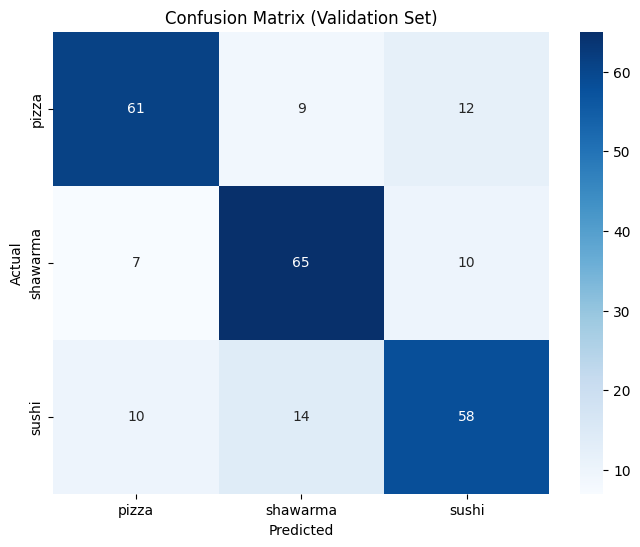

In [20]:
# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_train_encoded)), yticklabels=label_encoder.inverse_transform(np.unique(y_train_encoded)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [21]:
results_df['param_C'] = results_df['params'].apply(lambda x: x['C'])
results_df['param_max_iter'] = results_df['params'].apply(lambda x: x['max_iter'])
results_df['param_l1_ratio'] = results_df['params'].apply(lambda x: x.get('l1_ratio', None))  # Use .get() to handle missing 'l1_ratio'
results_df['param_solver'] = results_df['params'].apply(lambda x: x['solver'])

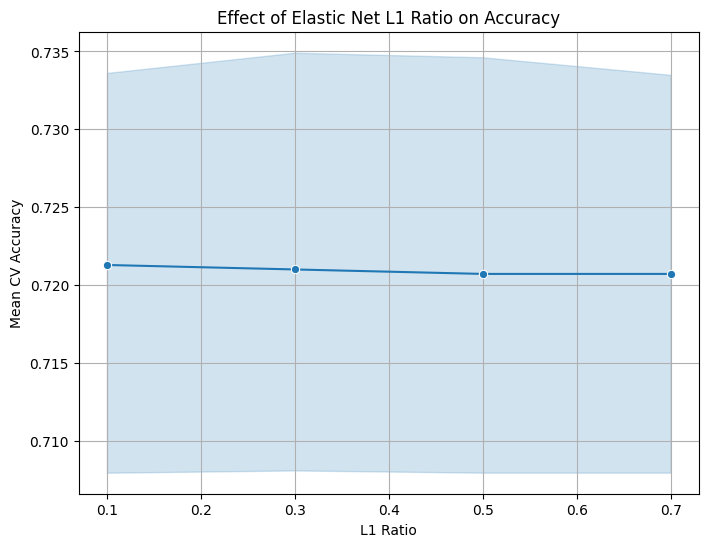

In [22]:
# Effect of penalty (Elastic Net - l1_ratio) on accuracy graph
if 'param_l1_ratio' in results_df.columns:
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='param_l1_ratio', y='mean_test_score', marker='o')
    plt.title('Effect of Elastic Net L1 Ratio on Accuracy')
    plt.xlabel('L1 Ratio')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.show()
else:
    print("Column 'param_l1_ratio' not found in results. Skipping plot.")

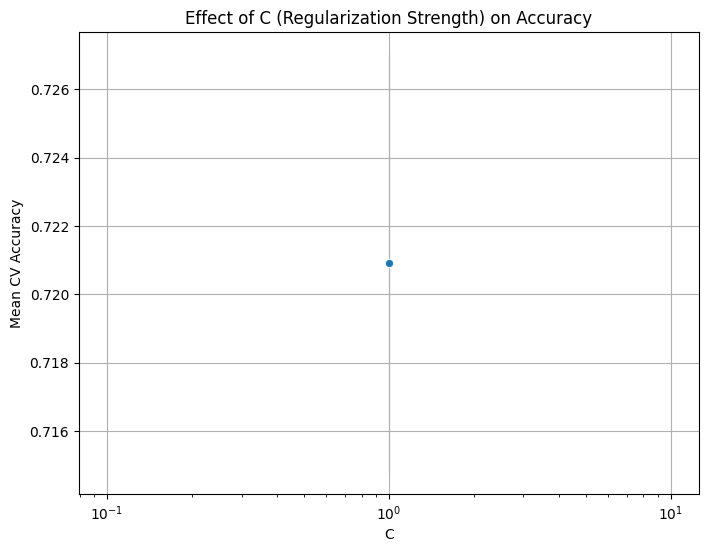

In [23]:
# Effect of C (regularization strength) on accuracy
if 'param_C' in results_df.columns:
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='param_C', y='mean_test_score', marker='o')
    plt.title('Effect of C (Regularization Strength) on Accuracy')
    plt.xlabel('C')
    plt.ylabel('Mean CV Accuracy')
    plt.xscale('log')  # log scale for C
    plt.grid(True)
    plt.show()
else:
    print("Column 'param_C' not found in results. Skipping plot.")

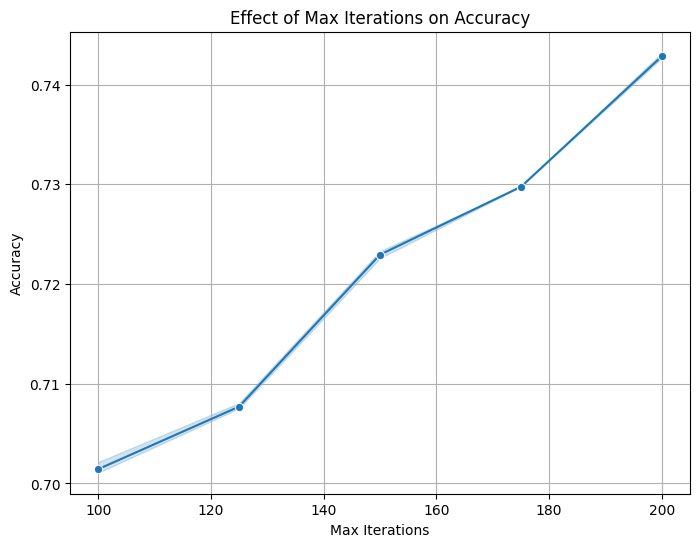

In [24]:
# Effect of max_iter on accuracy
if 'param_max_iter' in results_df.columns:
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='param_max_iter', y='mean_test_score', marker='o')
    plt.title('Effect of Max Iterations on Accuracy')
    plt.xlabel('Max Iterations')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
else:
    print("Column 'param_max_iter' not found in results. Skipping plot.")

In [25]:
def plot_hyperparameter_vs_accuracy(
    model_class, 
    hyperparameter_name, 
    hyperparameter_values, 
    X_train, y_train, 
    X_val, y_val, 
    fixed_params=None,
    categorical=False  # Set to True for categorical hyperparameters
):
    """
    Plots the effect of a single hyperparameter on training and validation accuracy.

    Parameters:
        model_class: The model class to use (e.g., RandomForestClassifier).
        hyperparameter_name (str): Name of the hyperparameter (e.g., "n_estimators").
        hyperparameter_values (list): List of values to test for the hyperparameter.
        X_train, y_train: Training data.
        X_val, y_val: Validation data.
        fixed_params (dict): Fixed hyperparameters for the model.
        categorical (bool): Whether the hyperparameter is categorical.
    """
    if fixed_params is None:
        fixed_params = {}

    # Lists to store accuracy values
    train_accuracy = []
    val_accuracy = []

    # Test different values of the hyperparameter
    for value in hyperparameter_values:
        # Initialize the model with the current hyperparameter value
        params = {hyperparameter_name: value, **fixed_params}
        model = model_class(**params)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Record training accuracy
        train_accuracy.append(model.score(X_train, y_train))
        
        # Record validation accuracy
        val_accuracy.append(model.score(X_val, y_val))

    # Plot the results
    plt.figure(figsize=(10, 6))
    
    if categorical:
        # Bar plot for categorical hyperparameters
        x = np.arange(len(hyperparameter_values))
        plt.bar(x - 0.2, train_accuracy, width=0.4, label="Training Accuracy")
        plt.bar(x + 0.2, val_accuracy, width=0.4, label="Validation Accuracy")
        plt.xticks(x, hyperparameter_values)
        
        # Annotate the bars with their accuracy values
        for i, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy)):
            plt.text(x[i] - 0.2, train_acc + 0.01, f"{train_acc:.2f}", ha='center', va='bottom')
            plt.text(x[i] + 0.2, val_acc + 0.01, f"{val_acc:.2f}", ha='center', va='bottom')
    else:
        # Line plot for numerical hyperparameters
        plot_values = [value if value is not None else 0 for value in hyperparameter_values]
        plt.plot(plot_values, train_accuracy, label="Training Accuracy", marker="o")
        plt.plot(plot_values, val_accuracy, label="Validation Accuracy", marker="o")
        plt.xticks(plot_values, hyperparameter_values)

    # Find the best value
    best_index = np.argmax(val_accuracy)
    best_value = hyperparameter_values[best_index]
    best_accuracy = val_accuracy[best_index]

    # # Highlight the best value
    # if categorical:
    #     plt.axvline(x=best_index, color="red", linestyle="--", label=f"Best {hyperparameter_name} = {best_value} (Val Acc={best_accuracy:.2f})")
    # else:
    #     plot_best_value = best_value if best_value is not None else 0
    #     plt.axvline(x=plot_best_value, color="red", linestyle="--", label=f"Best {hyperparameter_name} = {best_value} (Val Acc={best_accuracy:.2f})")

    plt.xlabel(hyperparameter_name)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {hyperparameter_name} on Accuracy ({model_class.__name__})")
    plt.legend()
    plt.grid()
    plt.show()

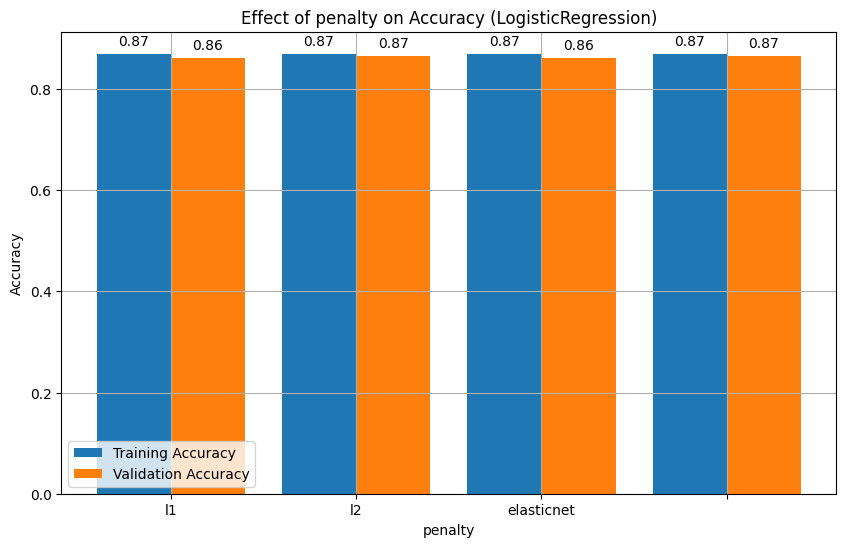

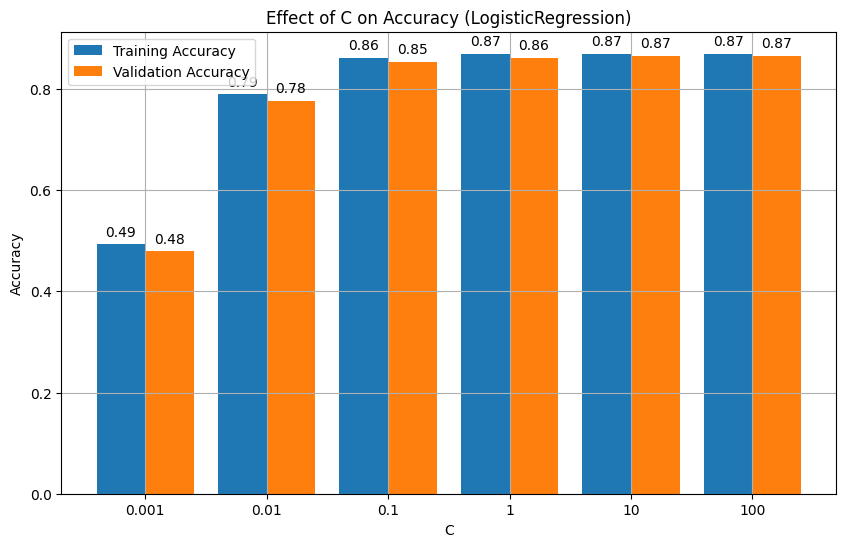

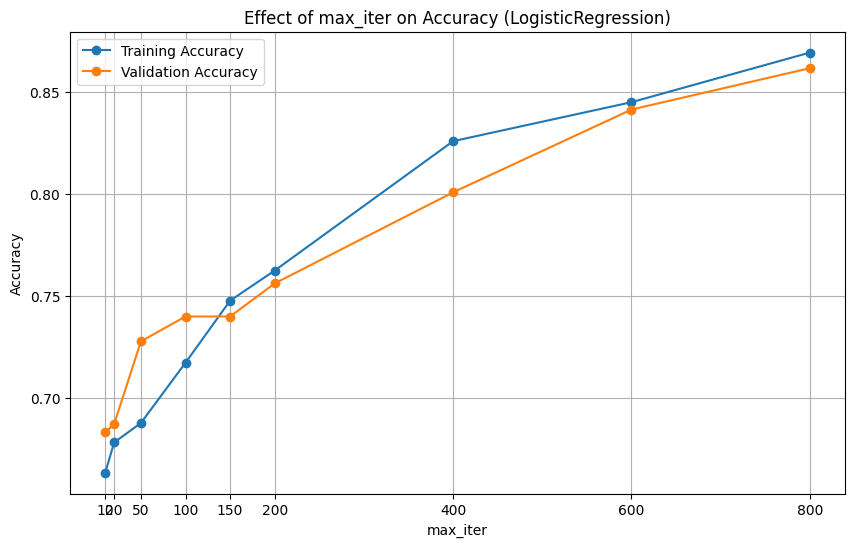

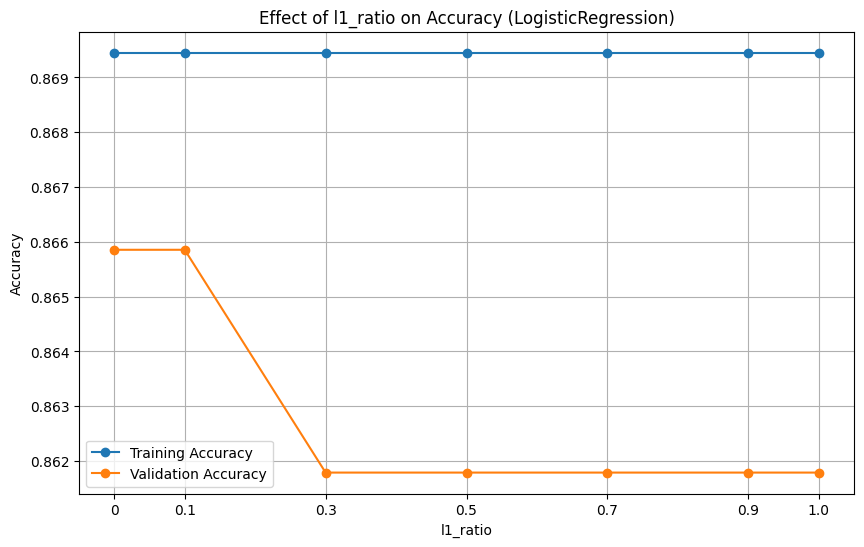

In [26]:
plot_hyperparameter_vs_accuracy(
    model_class=LogisticRegression,
    hyperparameter_name="penalty",
    hyperparameter_values=["l1", "l2", "elasticnet", None],
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"C": 1, "l1_ratio": 0.5, "max_iter": 800, "multi_class": "auto", "solver": "saga"},
    categorical=True
)

plot_hyperparameter_vs_accuracy(
    model_class=LogisticRegression,
    hyperparameter_name="C",
    hyperparameter_values=[0.001, 0.01, 0.1, 1, 10, 100],
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"l1_ratio": 0.5, "max_iter": 800, "multi_class": "auto", "penalty": "elasticnet", "solver": "saga"},
    categorical=True
)

# # Specifies the algorithm to use for optimization
# plot_hyperparameter_vs_accuracy(
#     model_class=LogisticRegression,
#     hyperparameter_name="solver",
#     hyperparameter_values=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     fixed_params={"max_iter": 1000},
#     categorical=True
# )

# Maximum number of iterations for the solver to converge (default is 100)
plot_hyperparameter_vs_accuracy(
    model_class=LogisticRegression,
    hyperparameter_name="max_iter",
    hyperparameter_values=[10, 20, 50, 100, 150, 200, 400, 600, 800],
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"C": 1, "l1_ratio": 0.5, "multi_class": "auto", "penalty": "elasticnet", "solver": "saga"},
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=LogisticRegression,
    hyperparameter_name="l1_ratio",
    hyperparameter_values=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"C": 1, "max_iter": 800, "multi_class": "auto", "penalty": "elasticnet", "solver": "saga"},
    categorical=False
)


# param_grid = {
#     'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
#     'max_iter': [25, 50, 100, 150, 200, 400, 600, 800, 1000],
#     'solver': ['saga'],
#     'penalty': ['elasticnet'],  # 'elasticnet' works only with 'saga'
#     'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0],     # Only used if penalty='elasticnet'
#     'multi_class': ['auto', 'multinomial']
# }


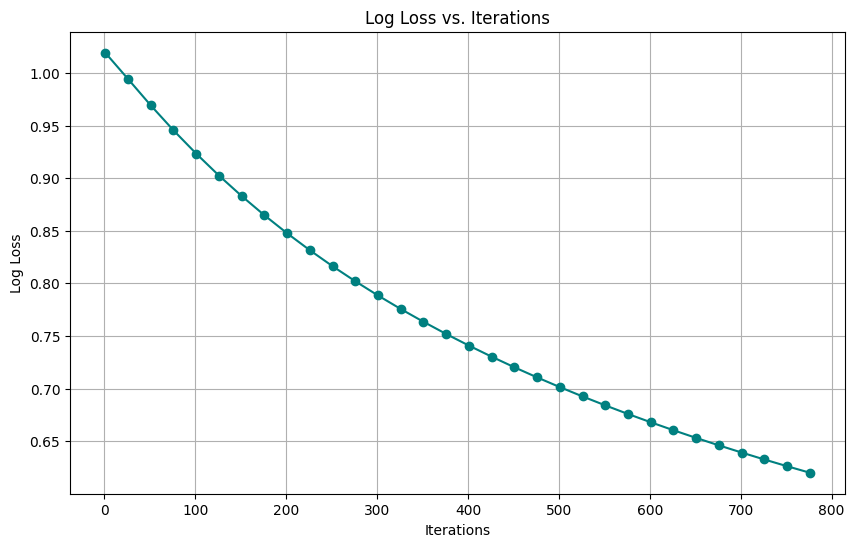

In [27]:
# from sklearn.metrics import accuracy_score, classification_report, log_loss, cohen_kappa_score, precision_recall_curve, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
# log loss vs iterations
losses = []
iterations = list(range(1, 800, 25))
for max_iter in iterations:
    temp_model = LogisticRegression(
        multi_class="auto", solver="saga", penalty="elasticnet", C=1, l1_ratio=0.7, max_iter=max_iter, random_state=42
    )
    temp_model.fit(X_train, y_train_encoded)
    temp_proba = temp_model.predict_proba(X_test)
    temp_loss = log_loss(y_test_encoded, temp_proba)
    losses.append(temp_loss)

plt.figure(figsize=(10, 6))
plt.plot(iterations, losses, marker='o', linestyle='-', color='teal')
plt.title("Log Loss vs. Iterations")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.grid()
plt.show()

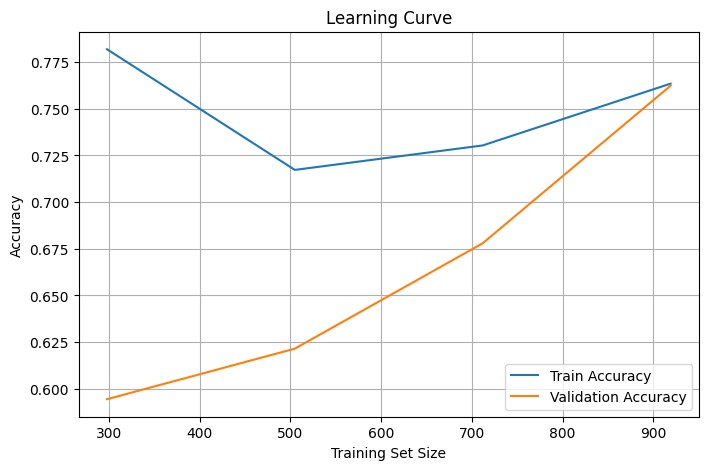

In [28]:
# learning curve
train_sizes, train_scores, val_scores = learning_curve(best_lr_model, X_train, y_train_encoded, cv=5)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

#  How we interpret this:
    # If the train accuracy was high and validation accuracy stayed low, it would indicate overfitting.
    # If both accuracies were low, it would suggest underfitting.
    # In your case, the validation accuracy catching up to train accuracy implies the model is generalizing well but might benefit from slightly stronger regularization to close the gap.

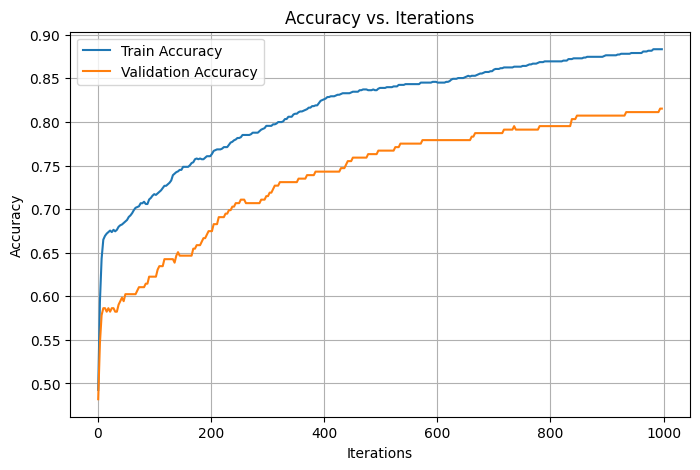

In [29]:
# Accuracy vs Iterations
iterations = range(1, 1000, 3)
train_accuracies = []
val_accuracies = []

for i in iterations:
    model = LogisticRegression(multi_class='auto', solver='saga', C=1, max_iter=i, penalty='elasticnet', l1_ratio=0.7, random_state=42)
    model.fit(X_train, y_train_encoded)
    train_accuracies.append(model.score(X_train, y_train_encoded))
    val_accuracies.append(model.score(X_test, y_test_encoded))

plt.figure(figsize=(8, 5))
plt.plot(iterations, train_accuracies, label='Train Accuracy')
plt.plot(iterations, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()